In [10]:

import tensorflow as tf
from glob import glob as glb

In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
from tensorflow.keras import datasets, layers, models

In [12]:
tf.__version__

'2.0.0'

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE


In [17]:
import pathlib
data_dir = '/home/frederik/flunnpy/Solutions_PNG'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*X.png')))
image_count
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['No8_A_0-0009_L0-1235', 'No7_A_0-00_L0-11'], dtype='<U20')

In [23]:
CLASS_NAMES[0]

'No8_A_0-0009_L0-1235'

In [15]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


In [18]:
BATCH_SIZE = 4
IMG_HEIGHT = 256
IMG_WIDTH = 256
shape=[IMG_HEIGHT,IMG_WIDTH]
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
rescale=1./255

In [25]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))


Found 8 images belonging to 2 classes.


In [9]:
imgX=tf.keras.preprocessing.image.load_img(
    data_dir/'X/No7_A_0-00_L0-11_cavity_vel_1_X.png',
    color_mode="grayscale",
    target_size=shape,
    interpolation='nearest'
)
imgY=tf.keras.preprocessing.image.load_img(
    data_dir/'Y/No7_A_0-00_L0-11_cavity_vel_1_Y.png',
    color_mode="grayscale",
    target_size=shape,
    interpolation='nearest'
)
imgP=tf.keras.preprocessing.image.load_img(
    data_dir/'P/No7_A_0-00_L0-11_cavity_vel_1_P.png',
    color_mode="grayscale",
    target_size=shape,
    interpolation='nearest'   
)
imgMesh=tf.keras.preprocessing.image.load_img(
    data_dir/'Mesh/No7_A_0-00_L0-11_cavity_vel_1_Mesh.png',
    color_mode="grayscale",
    target_size=shape,
    interpolation='nearest'   
)

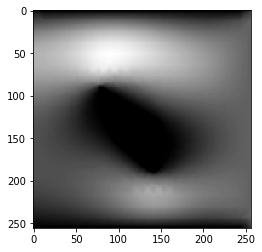

In [10]:
img_ArrX=tf.keras.preprocessing.image.img_to_array(
    imgX,
    data_format="channels_last",
    dtype=None
)
img_ArrY=tf.keras.preprocessing.image.img_to_array(
    imgY,
    data_format="channels_last",
    dtype=None
)
img_ArrP=tf.keras.preprocessing.image.img_to_array(
    imgP,
    data_format="channels_last",
    dtype=None
)
img_ArrMesh=tf.keras.preprocessing.image.img_to_array(
    imgMesh,
    data_format="channels_last",
    dtype=None
)
sflow=np.concatenate((img_ArrX,img_ArrY),axis=2)#
sflow=sflow*rescale
boundary=img_ArrMesh*rescale

#img_Arr1[:,:,]=img_Arr
#img_Arr1[800,800,0]
plt.imshow(sflow[:,:,0],cmap='gray')
#img_Arr1.shape

In [11]:
boundary.shape

(256, 256, 1)

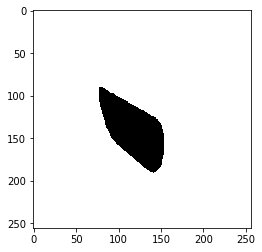

In [12]:
boundary1 = np.expand_dims(boundary, axis=0)
sflow1 = np.expand_dims(sflow, axis=0)
plt.imshow(boundary1[0,:,:,0],cmap='gray')

In [13]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(4):
      ax = plt.subplot(1,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')


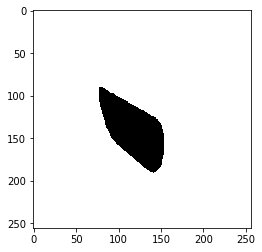

In [14]:
#image_batch, label_batch = next(train_data_gen)
#show_batch(image_batch, label_batch)
image_batch=boundary1
label_batch=sflow1
plt.imshow(image_batch[0,:,:,0],cmap='gray')

In [27]:
label_batch.shape

NameError: name 'label_batch' is not defined

In [16]:
# class MyConv2DTransposeLayer(tf.keras.layers.Layer):
#   def __init__(self, num_outputs):
#     super(MyConv2DTransposeLayer, self).__init__()
#     self.num_outputs = num_outputs

#   def build(self, input_shape):
#     self.kernel = self.add_variable("kernel",
#                                     shape=[int(input_shape[-1]),
#                                            self.num_outputs])

#   def call(self, input):
#     return tf.matmul(input, self.kernel)

# layer = MyDenseLayer(10)


In [17]:
Conv_initializer=tf.keras.initializers.GlorotNormal(seed=0)
TranspConv_initializer=tf.keras.initializers.GlorotNormal(seed=0)

In [18]:
def identity_block(x,f,filters,stage,block):
    conv_name_base='res'+str(stage)+block+'_branch'
    bn_name_base='bn'+str(stage)+block+'_branch'
    F1,F2,F3=filters
    X_Shortcut=x
    
    
    x=layers.Conv2D(F1,(1,1),strides=(1,1),padding='valid',kernel_initializer=Conv_initializer,
                    name=conv_name_base+'2a')(x)
    x=layers.BatchNormalization()(x)
    #x=layers.Dropout(0.5)(x)
    x=layers.LeakyReLU(0.2)(x)
   
    
    x=layers.Conv2D(F2,(f,f),strides=(1,1),padding='same',kernel_initializer=Conv_initializer,
                   name=conv_name_base+'2b')(x)
    x=layers.LeakyReLU(0.2)(x)
    
    
    x=layers.Conv2D(F3,(1,1),strides=(1,1),padding='valid',kernel_initializer=Conv_initializer,
                   name=conv_name_base+'2c')(x)
    x=layers.LeakyReLU(0.2)(x)
    
    
    x=layers.Add()([x,X_Shortcut])
    x=layers.LeakyReLU()(x)
    return x
    
    

In [19]:
def convolutional_block(x,f,filters,stage,block, s=2):
    conv_name_base='res'+str(stage)+block+'_branch'
    bn_name_base='bn'+str(stage)+block+'_branch'
    F1,F2,F3=filters
    X_Shortcut=x
    
    x=layers.Conv2D(F1,(1,1),strides=(s,s),padding='valid',kernel_initializer=Conv_initializer,
                    name=conv_name_base+'2a')(x)
    x=layers.BatchNormalization()(x)
    #x=layers.Dropout(0.5)(x)
    x=layers.LeakyReLU(0.2)(x)
   
    
    x=layers.Conv2D(F2,(f,f),strides=(1,1),padding='same',kernel_initializer=Conv_initializer,
                   name=conv_name_base+'2b')(x)
    
    x=layers.LeakyReLU(0.2)(x)
    
    
    x=layers.Conv2D(F3,(1,1),strides=(1,1),padding='valid',kernel_initializer=Conv_initializer,
                   name=conv_name_base+'2c')(x)
    x=layers.LeakyReLU(0.2)(x)
    
    
    X_Shortcut=layers.Conv2D(F3, (1,1),strides=(s,s),
                             padding='valid',kernel_initializer=Conv_initializer,
                             name=conv_name_base+'1')(X_Shortcut)
    X_Shortcut=layers.LeakyReLU(0.2)(X_Shortcut)
    x=layers.Add()([x,X_Shortcut])
    x=layers.LeakyReLU()(x)
    return x
    

In [20]:
def Transp_convolutional_block(x,f,filters,stage,block, s=2,apply_droupout=False):
    TranspConv_initializer=tf.keras.initializers.GlorotNormal(seed=0)
    Transp_conv_name_base='res'+str(stage)+block+'_branch'
    bn_name_base='bn'+str(stage)+block+'_branch'
    F1,F2,F3=filters
    X_Shortcut=x
    
    x1=layers.Conv2DTranspose(filter_size, 
                              (3,3),strides=(1,1),
                              padding='same',
                              kernel_initializer=TranspConv_initializer,
                             name=Transp_conv_name_base+'1')(x)

    
    x=layers.BatchNormalization()(x)
    if apply_droput:
            x=layers.Dropout(0.5)
    x=layers.ReLU()(x)
    return x

In [21]:
#def downsample(filters,size):
    

In [22]:
from tensorflow import keras
from tensorflow.keras import layers
tf.keras.backend.clear_session()
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
filter_size=8
kernel_size_w=3
filter_sizeIn=filter_size
#(inputs)

#Stage 1
stage=1
x=layers.Conv2D(filter_size, (kernel_size_w,kernel_size_w ),
                strides=(1,1),padding='same',kernel_initializer=Conv_initializer)(inputs)
#x=layers.Dropout(0.1)(x)
#x=layers.LeakyReLU()(x)

filter_size=filter_size*2

#Stage 2
stage=stage+1
x=convolutional_block(x,f=3,filters=[filter_size,filter_size,filter_size*3],stage=2,block='a',s=2)
x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=2,block='b')
#x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=2,block='c')

filter_size=filter_size*2

#Stage 3
stage=stage+1
x=convolutional_block(x,f=3,filters=[filter_size,filter_size,filter_size*3],stage=3,block='a',s=2)
x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=3,block='b')
#x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=3,block='c')
#x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=3,block='d')

filter_size=filter_size*2


#Stage 4
stage=stage+1
x=convolutional_block(x,f=3,filters=[filter_size,filter_size,filter_size*3],stage=4,block='a',s=2)
x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=4,block='b')
#x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=4,block='c')
#x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=4,block='d')
#x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=4,block='e')
#x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=4,block='f')

filter_size=filter_size*2


#Stage 5
stage=stage+1
x=convolutional_block(x,f=3,filters=[filter_size,filter_size,filter_size*3],stage=stage,block='a',s=2)
x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=stage,block='b')
#x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=stage,block='c')
# #x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=4,block='d')
# #x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=4,block='e')
# #x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=4,block='f')

filter_size=filter_size*2


#Stage 6
stage=stage+1
x=convolutional_block(x,f=3,filters=[filter_size,filter_size,filter_size*3],stage=stage,block='a',s=1)
x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=stage,block='b')
#x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=stage,block='c')
# #x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=4,block='d')
# #x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=4,block='e')
# #x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=4,block='f')

filter_size=filter_size*2

# #Stage 7
stage=stage+1
x=convolutional_block(x,f=3,filters=[filter_size,filter_size,filter_size*3],stage=stage,block='a',s=1)
x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=stage,block='b')
# #x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=stage,block='c')
# # #x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=4,block='d')
# # #x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=4,block='e')
###x=identity_block(x,3,[filter_size,filter_size,filter_size*3],stage=4,block='f')

filter_size=filter_size*2




#Dense Layer

x=layers.Dense(filter_size)(x)
x=layers.ReLU()(x)
#x=layers.Dropout(0.1)(x)
#x=layers.LeakyReLU()(x)
filter_sizeTransp=filter_size ## Save Filter size for x2 outputs
filter_size=int(filter_size/2)

#Stage 1_1
stage=stage+1
x1=layers.Conv2DTranspose(filter_size, (2,2),strides=(1,1),padding='same',kernel_initializer=TranspConv_initializer)(x)
#x1=convolutional_block(x1,f=3,filters=[filter_size,filter_size,filter_size*3],stage=stage,block='a',s=1)
#x1=identity_block(x1,3,[filter_size,filter_size,filter_size*3],stage=stage,block='b')
#x1=identity_block(x1,3,[filter_size,filter_size,filter_size*3],stage=stage,block='c')


#x1=layers.Dropout(0.5)(x1)
x1=layers.BatchNormalization()(x1)
#x1=layers.LeakyReLU( alpha=0.3)(x1)
x1=layers.ReLU()(x1)


#Stage 1_2
filter_size=int(filter_size/2)
stage=stage+1
x1=layers.Conv2DTranspose(filter_size, (3,3),strides=(2,2),padding='same',kernel_initializer=TranspConv_initializer)(x1)
# x1=convolutional_block(x1,f=3,filters=[filter_size,filter_size,filter_size*3],stage=stage,block='a',s=1)
# x1=identity_block(x1,3,[filter_size,filter_size,filter_size*3],stage=stage,block='b')
# x1=identity_block(x1,3,[filter_size,filter_size,filter_size*3],stage=stage,block='c')

#x1=layers.Dropout(0.1)(x1)
x1=layers.BatchNormalization()(x1)
#x1=layers.LeakyReLU( alpha=0.3)(x1)
x1=layers.ReLU()(x1)

#Stage 1_3
filter_size=int(filter_size/2)
stage=stage+1
x1=layers.Conv2DTranspose(filter_size, (3,3),strides=(2,2),padding='same',kernel_initializer=TranspConv_initializer)(x1)
# x1=convolutional_block(x1,f=3,filters=[filter_size,filter_size,filter_size*3],stage=stage,block='a',s=1)
# x1=identity_block(x1,3,[filter_size,filter_size,filter_size*3],stage=stage,block='b')
# x1=identity_block(x1,3,[filter_size,filter_size,filter_size*3],stage=stage,block='c')
#x1=layers.LeakyReLU( alpha=0.3)(x1)
x1=layers.BatchNormalization()(x1)
x1=layers.ReLU()(x1)


#Stage 1_4
filter_size=int(filter_size/2)
stage=stage+1
x1=layers.Conv2DTranspose(filter_size, (3,3),strides=(2,2),padding='same',kernel_initializer=TranspConv_initializer)(x1)
# x1=convolutional_block(x1,f=3,filters=[filter_size,filter_size,filter_size*3],stage=stage,block='a',s=1)
# x1=identity_block(x1,3,[filter_size,filter_size,filter_size*3],stage=stage,block='b')
# x1=identity_block(x1,3,[filter_size,filter_size,filter_size*3],stage=stage,block='c')
#x1=layers.LeakyReLU( alpha=0.3)(x1)
x1=layers.BatchNormalization()(x1)
x1=layers.ReLU()(x1)


#Stage 1_5
filter_size=int(filter_size/2)
stage=stage+1
x1=layers.Conv2DTranspose(filter_size, (3,3),strides=(2,2),padding='same',kernel_initializer=TranspConv_initializer)(x1)
# x1=convolutional_block(x1,f=3,filters=[filter_size,filter_size,filter_size*3],stage=stage,block='a',s=1)
# x1=identity_block(x1,3,[filter_size,filter_size,filter_size*3],stage=stage,block='b')
# x1=identity_block(x1,3,[filter_size,filter_size,filter_size*3],stage=stage,block='c')
#x1=layers.LeakyReLU( alpha=0.3)(x1)
x1=layers.BatchNormalization()(x1)
x1=layers.ReLU()(x1)


#Stage 1_6
filter_size=int(filter_size/2)
stage=stage+1
x1=layers.Conv2DTranspose(filter_size, (3,3),strides=(1,1),padding='same',kernel_initializer=TranspConv_initializer)(x1)
# x1=convolutional_block(x1,f=3,filters=[filter_size,filter_size,filter_size*3],stage=stage,block='a',s=1)
# x1=identity_block(x1,3,[filter_size,filter_size,filter_size*3],stage=stage,block='b')
# x1=identity_block(x1,3,[filter_size,filter_size,filter_size*3],stage=stage,block='c')
#x1=layers.LeakyReLU( alpha=0.3)(x1)
x1=layers.BatchNormalization()(x1)
x1=layers.ReLU()(x1)


#Stage 1_7
filter_size=int(filter_size/2)
stage=stage+1
x1=layers.Conv2DTranspose(filter_size, (3,3),strides=(1,1),padding='same',kernel_initializer=TranspConv_initializer)(x1)
# x1=convolutional_block(x1,f=3,filters=[filter_size,filter_size,filter_size*3],stage=stage,block='a',s=1)
# x1=identity_block(x1,3,[filter_size,filter_size,filter_size*3],stage=stage,block='b')
# x1=identity_block(x1,3,[filter_size,filter_size,filter_size*3],stage=stage,block='c')
#x1=layers.LeakyReLU( alpha=0.3)(x1)
#x1=layers.BatchNormalization()(x1)
#x1=layers.ReLU()(x1)
x1=layers.Activation('tanh')(x1)
outputs_X=layers.Conv2DTranspose(1, (2, 2),padding='same',name='outputs_X')(x1)

#Stage 2_1
stage=stage+1

filter_size=filter_sizeTransp
filter_size=int(filter_size/2)

x2=layers.Conv2DTranspose(filter_size, (3,3),strides=(1,1),padding='same',kernel_initializer=TranspConv_initializer)(x)
# x2=convolutional_block(x2,f=3,filters=[filter_size,filter_size,filter_size*3],stage=stage,block='a',s=1)
# x2=identity_block(x2,3,[filter_size,filter_size,filter_size*3],stage=stage,block='b')
# x2=identity_block(x2,3,[filter_size,filter_size,filter_size*3],stage=stage,block='c')
#x2=layers.Dropout(0.1)(x2)
#x2=layers.LeakyReLU( alpha=0.3)(x2)
x2=layers.BatchNormalization()(x2)
x2=layers.ReLU()(x2)


#Stage 2_2
stage=stage+1
filter_size=int(filter_size/2)
x2=layers.Conv2DTranspose(filter_size, (3,3),strides=(2,2),padding='same',kernel_initializer=TranspConv_initializer)(x2)
# x2=convolutional_block(x2,f=3,filters=[filter_size,filter_size,filter_size*3],stage=stage,block='a',s=1)
# x2=identity_block(x2,3,[filter_size,filter_size,filter_size*3],stage=stage,block='b')
# x2=identity_block(x2,3,[filter_size,filter_size,filter_size*3],stage=stage,block='c')

#x2=layers.Dropout(0.1)(x2)
#x2=layers.LeakyReLU( alpha=0.3)(x2)
x2=layers.BatchNormalization()(x2)
x2=layers.ReLU()(x2)



#Stage 2_3
stage=stage+1
filter_size=int(filter_size/2)
x2=layers.Conv2DTranspose(filter_size, (3,3),strides=(2,2),padding='same',kernel_initializer=TranspConv_initializer)(x2)
# x2=convolutional_block(x2,f=3,filters=[filter_size,filter_size,filter_size*3],stage=stage,block='a',s=1)
# x2=identity_block(x2,3,[filter_size,filter_size,filter_size*3],stage=stage,block='b')
# x2=identity_block(x2,3,[filter_size,filter_size,filter_size*3],stage=stage,block='c')

#x2=layers.Dropout(0.1)(x2)
#x2=layers.LeakyReLU( alpha=0.3)(x2)
x2=layers.BatchNormalization()(x2)
x2=layers.ReLU()(x2)

#Stage 2_4
stage=stage+1
filter_size=int(filter_size/2)
x2=layers.Conv2DTranspose(filter_size, (3,3),strides=(2,2),padding='same',kernel_initializer=TranspConv_initializer)(x2)
# x2=convolutional_block(x2,f=3,filters=[filter_size,filter_size,filter_size*3],stage=stage,block='a',s=1)
# x2=identity_block(x2,3,[filter_size,filter_size,filter_size*3],stage=stage,block='b')
# x2=identity_block(x2,3,[filter_size,filter_size,filter_size*3],stage=stage,block='c')

#x2=layers.Dropout(0.1)(x2)
#x2=layers.LeakyReLU( alpha=0.3)(x2)
x2=layers.BatchNormalization()(x2)
x2=layers.ReLU()(x2)

#Stage 2_5
stage=stage+1
filter_size=int(filter_size/2)
x2=layers.Conv2DTranspose(filter_size, (3,3),strides=(2,2),padding='same',kernel_initializer=TranspConv_initializer)(x2)
# x2=convolutional_block(x2,f=3,filters=[filter_size,filter_size,filter_size*3],stage=stage,block='a',s=1)
# x2=identity_block(x2,3,[filter_size,filter_size,filter_size*3],stage=stage,block='b')
# x2=identity_block(x2,3,[filter_size,filter_size,filter_size*3],stage=stage,block='c')

#x2=layers.Dropout(0.1)(x2)
#x2=layers.LeakyReLU( alpha=0.3)(x2)
x2=layers.BatchNormalization()(x2)
x2=layers.ReLU()(x2)

#Stage 2_6
stage=stage+1
filter_size=int(filter_size/2)
x2=layers.Conv2DTranspose(filter_size, (3,3),strides=(1,1),padding='same',kernel_initializer=TranspConv_initializer)(x2)
# x2=convolutional_block(x2,f=3,filters=[filter_size,filter_size,filter_size*3],stage=stage,block='a',s=1)
# x2=identity_block(x2,3,[filter_size,filter_size,filter_size*3],stage=stage,block='b')
# x2=identity_block(x2,3,[filter_size,filter_size,filter_size*3],stage=stage,block='c')

#x2=layers.Dropout(0.1)(x2)
#x2=layers.LeakyReLU( alpha=0.3)(x2)
x2=layers.BatchNormalization()(x2)
x2=layers.ReLU()(x2)


#stage 2_7

stage=stage+1
filter_size=int(filter_size/2)
x2=layers.Conv2DTranspose(filter_size, (3,3),strides=(1,1),padding='same',kernel_initializer=TranspConv_initializer)(x2)
# x2=convolutional_block(x2,f=3,filters=[filter_size,filter_size,filter_size*3],stage=stage,block='a',s=1)
# x2=identity_block(x2,3,[filter_size,filter_size,filter_size*3],stage=stage,block='b')
# x2=identity_block(x2,3,[filter_size,filter_size,filter_size*3],stage=stage,block='c')

#x2=layers.Dropout(0.1)(x2)
#x2=layers.LeakyReLU( alpha=0.3)(x2)
#x2=layers.BatchNormalization()(x2)
#x2=layers.ReLU()(x2)
x2=layers.Activation('tanh')(x2)


outputs_Y=layers.Conv2DTranspose(1, (2, 2),padding='same',name='outputs_Y')(x2)
#output =layers.concatenate([outputs_X,outputs_Y], axis=3)


flu1=keras.Model(inputs=inputs,outputs=[outputs_X,outputs_Y])
flu1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
res2a_branch2a (Conv2D)         (None, 128, 128, 16) 144         conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          res2a_branch2a[0][0]             
______________________________________________________________________________________________

In [23]:
#asdf  
#keras.utils.plot_model(flu1, 'multi_input_and_output_model.png', show_shapes=True)

In [24]:
#asdf

In [25]:
#asdf

# generator = make_generator_model()

# noise = tf.random.normal([1, 100])
# generated_image = generator(noise, training=False)

# plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [26]:
def loss_imX(sflow,outputs_X):
    #loss=tf.nn.l2_loss(outputs_X-sflow[:,:,0])
    loss=tf.nn.l2_loss(outputs_X-sflow)
    #loss=tf.math.reduce_mean(outputs_X-sflow)
    tf.summary.scalar('lossX', loss)
    return loss
def loss_imY(sflow,outputs_Y):
    #loss=tf.nn.l2_loss(outputs_Y-sflow[:,:,1])
    loss=tf.nn.l2_loss(outputs_Y-sflow)
    tf.summary.scalar('lossY', loss)
    return loss
def loss_im(sflow,outputs):
    #loss=tf.nn.l2_loss(outputs_Y-sflow[:,:,1])
    loss=tf.nn.l2_loss(outputs-sflow)
    tf.summary.scalar('lossXandY', loss)
    return loss


In [27]:
sflow[:,:,1]

array([[0.32156864, 0.32156864, 0.32156864, ..., 0.31764707, 0.31764707,
        0.31764707],
       [0.32156864, 0.32156864, 0.32156864, ..., 0.3254902 , 0.3254902 ,
        0.31764707],
       [0.3254902 , 0.3254902 , 0.3254902 , ..., 0.33333334, 0.3254902 ,
        0.31764707],
       ...,
       [0.3137255 , 0.3137255 , 0.3137255 , ..., 0.3137255 , 0.3137255 ,
        0.3137255 ],
       [0.3137255 , 0.3137255 , 0.3137255 , ..., 0.3137255 , 0.3137255 ,
        0.3137255 ],
       [0.3137255 , 0.3137255 , 0.3137255 , ..., 0.3137255 , 0.3137255 ,
        0.3137255 ]], dtype=float32)

In [28]:
flu1.compile(optimizer=tf.keras.optimizers.Adam(5e-4),
              #loss=loss_im,
              loss={'outputs_X': loss_imX,
                    'outputs_Y': loss_imY},

             metrics=['accuracy'])
# Save weights to a TensorFlow Checkpoint file
#flu1.save_weights('./weights/my_model')

# Restore the model's state,
# this requires a model with the same architecture.
#model.load_weights('./weights/my_model')


In [29]:
import datetime
!rm -rf logs
log_dir = "logs/train_data/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir)
#with file_writer.as_default():
 # tf.summary.image("Training data", img, step=0)

    
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)



In [30]:
# %load_ext tensorboard
# %reload_ext tensorboard
# %tensorboard --logdir logs/train_data/

In [31]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                #save_best_only=True,
                                                period=10)
#cp_callback

In [32]:
callbacks=[
    cp_callback
#      keras.callbacks.ModelCheckpoint(
#         filepath='flu1_{epoch}.h5',
#         # Path where to save the model
#         # The two parameters below mean that we will overwrite
#         # the current checkpoint if and only if
#         # the `val_loss` score has improved.
#         save_best_only=True,
#         monitor='loss',
#         verbose=1),
    #tensorboard_callback    
]

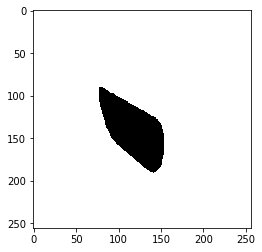

In [33]:
plt.imshow(image_batch[0,:,:,0],cmap='gray')

In [54]:
#flu1.save_weights(checkpoint_path)
flu1.load_weights(checkpoint_path)

In [47]:
#history = flu1.fit(image_batch, epochs=1,callbacks=[tensorboard_callback])
#asdf
history = flu1.fit(image_batch, {'outputs_X':label_batch[:,:,:,0],'outputs_Y':label_batch[:,:,:,1]}, epochs=10000,callbacks=callbacks)
#history = flu1.fit(image_batch, label_batch, epochs=100,callbacks=callbacks)

Train on 1 samples
Epoch 1/10000

Epoch 00001: saving model to training_1/cp.ckpt
1/1 [==============================] - 2s 2s/sample - loss: 45.6156 - outputs_X_loss: 21.8364 - outputs_Y_loss: 23.7792 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 2/10000
1/1 [==============================] - 1s 1s/sample - loss: 45.2982 - outputs_X_loss: 21.7534 - outputs_Y_loss: 23.5448 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 3/10000
1/1 [==============================] - 1s 1s/sample - loss: 45.2311 - outputs_X_loss: 21.8765 - outputs_Y_loss: 23.3547 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 4/10000
1/1 [==============================] - 1s 1s/sample - loss: 45.6854 - outputs_X_loss: 22.4922 - outputs_Y_loss: 23.1933 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 5/10000
1/1 [==============================] - 1s 1s/sample - loss: 46.3650 - outputs_X_loss: 23.2681 - outputs_Y_loss: 23.0969 - outputs_X_accuracy: 0.0696 -

Epoch 43/10000
1/1 [==============================] - 1s 1s/sample - loss: 31.1015 - outputs_X_loss: 14.1559 - outputs_Y_loss: 16.9456 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 44/10000
1/1 [==============================] - 1s 1s/sample - loss: 31.6593 - outputs_X_loss: 14.5799 - outputs_Y_loss: 17.0794 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 45/10000
1/1 [==============================] - 1s 1s/sample - loss: 31.2435 - outputs_X_loss: 14.3475 - outputs_Y_loss: 16.8960 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 46/10000
1/1 [==============================] - 1s 1s/sample - loss: 30.2695 - outputs_X_loss: 13.7417 - outputs_Y_loss: 16.5279 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 47/10000
1/1 [==============================] - 1s 1s/sample - loss: 29.9936 - outputs_X_loss: 13.6177 - outputs_Y_loss: 16.3759 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 48/10000
1/1 [===============

Epoch 85/10000
1/1 [==============================] - 2s 2s/sample - loss: 25.5858 - outputs_X_loss: 11.5513 - outputs_Y_loss: 14.0345 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 86/10000
1/1 [==============================] - 2s 2s/sample - loss: 24.6628 - outputs_X_loss: 11.6388 - outputs_Y_loss: 13.0240 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 87/10000
1/1 [==============================] - 2s 2s/sample - loss: 25.1687 - outputs_X_loss: 11.3094 - outputs_Y_loss: 13.8592 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 88/10000
1/1 [==============================] - 1s 1s/sample - loss: 24.2680 - outputs_X_loss: 11.1897 - outputs_Y_loss: 13.0783 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 89/10000
1/1 [==============================] - 1s 1s/sample - loss: 23.8801 - outputs_X_loss: 10.9032 - outputs_Y_loss: 12.9768 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 90/10000
1/1 [===============

Epoch 127/10000
1/1 [==============================] - 1s 1s/sample - loss: 18.4422 - outputs_X_loss: 8.3014 - outputs_Y_loss: 10.1409 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 128/10000
1/1 [==============================] - 2s 2s/sample - loss: 18.8309 - outputs_X_loss: 8.5372 - outputs_Y_loss: 10.2937 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 129/10000
1/1 [==============================] - 2s 2s/sample - loss: 19.4383 - outputs_X_loss: 8.8134 - outputs_Y_loss: 10.6249 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 130/10000
1/1 [==============================] - 1s 1s/sample - loss: 20.4514 - outputs_X_loss: 9.2099 - outputs_Y_loss: 11.2415 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 131/10000

Epoch 00131: saving model to training_1/cp.ckpt
1/1 [==============================] - 2s 2s/sample - loss: 21.7855 - outputs_X_loss: 9.7175 - outputs_Y_loss: 12.0680 - outputs_X_accuracy: 0.0696 - outputs_Y_acc

Epoch 169/10000
1/1 [==============================] - 2s 2s/sample - loss: 14.6495 - outputs_X_loss: 6.6750 - outputs_Y_loss: 7.9744 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 170/10000
1/1 [==============================] - 2s 2s/sample - loss: 14.5439 - outputs_X_loss: 6.6147 - outputs_Y_loss: 7.9292 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 171/10000

Epoch 00171: saving model to training_1/cp.ckpt
1/1 [==============================] - 2s 2s/sample - loss: 14.4694 - outputs_X_loss: 6.5861 - outputs_Y_loss: 7.8832 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 172/10000
1/1 [==============================] - 1s 1s/sample - loss: 14.4095 - outputs_X_loss: 6.5677 - outputs_Y_loss: 7.8419 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 173/10000
1/1 [==============================] - 1s 1s/sample - loss: 14.3473 - outputs_X_loss: 6.5397 - outputs_Y_loss: 7.8076 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy

Epoch 211/10000

Epoch 00211: saving model to training_1/cp.ckpt
1/1 [==============================] - 2s 2s/sample - loss: 12.3132 - outputs_X_loss: 5.6771 - outputs_Y_loss: 6.6361 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 212/10000
1/1 [==============================] - 2s 2s/sample - loss: 12.2312 - outputs_X_loss: 5.6097 - outputs_Y_loss: 6.6215 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 213/10000
1/1 [==============================] - 1s 1s/sample - loss: 12.0571 - outputs_X_loss: 5.5362 - outputs_Y_loss: 6.5209 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 214/10000
1/1 [==============================] - 1s 1s/sample - loss: 11.9782 - outputs_X_loss: 5.5360 - outputs_Y_loss: 6.4421 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy: 0.0652
Epoch 215/10000
1/1 [==============================] - 1s 1s/sample - loss: 12.0074 - outputs_X_loss: 5.5726 - outputs_Y_loss: 6.4348 - outputs_X_accuracy: 0.0696 - outputs_Y_accuracy

KeyboardInterrupt: 

In [48]:
#model.evaluate(boundary1, verbose=3)
predictions = flu1.predict(boundary1)
#predictions
#predictions.shape

#plt.imshow(predictions[:,:,:,0],cmap='Greys')
#boundary1.shape

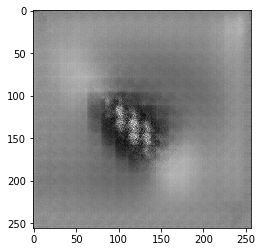

In [49]:
predictions=np.array(predictions)#
predictions.shape
plt.imshow(predictions[1,0,:,:,0],cmap='gray')

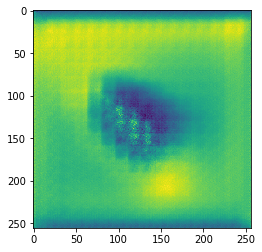

In [50]:
test=(predictions[1,:,:]+predictions[0,:,:])
plt.imshow(test[0,:,:,0])

In [51]:
LossX=sflow[:,:,0]-predictions[0,0,:,:,:]
LossY=sflow[:,:,1]-predictions[1,0,:,:,:]

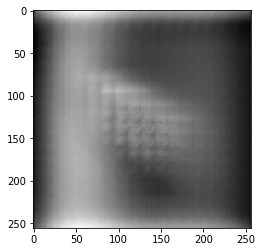

In [52]:
plt.imshow(LossX[:,:,0],cmap='gray')

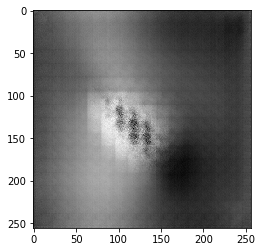

In [53]:
plt.imshow(LossY[:,:,0],cmap='gray')

In [ ]:
keep_prob

In [ ]:
tf.keras.backend.clear_session()
sflow_p=inference(boundary1, keep_prob)
res.summary()

In [ ]:
tf.keras.backend.clear_session()
res = models.Sequential()
res.add()